#**Sentiment Analysis on IMDB movie reviews**
by Favour Onyido

#Importing important libraries

In [26]:
#Data exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image


#Natural language toolkit
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

#re for regular expression
import re

#tqdm to track loop progress
from tqdm import tqdm

#sklearn for modelling
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score


In [27]:
#Save your csv file in your google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
#Navigate to the drive folder where you have your csv file
%cd /content/drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


#Data Exploration and Processing

In [29]:
#Loading the datafram
df = pd.read_csv('IMDB_Dataset.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [30]:
#Remapping the sentiment column with 1 and 0 representing 'positive' and 'negative' respectively
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

In [31]:
#Viewing the number of positive and negative sentiments in the dataset
values, counts = np.unique(df['sentiment'], return_counts=True)
print(values, counts)

[0 1] [25000 25000]


(0.0, 250.0)

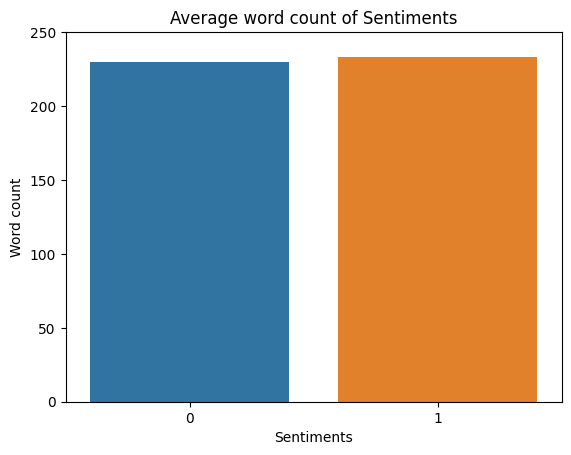

In [32]:
import seaborn as sns
#Add a new column that contains the number of words in the review
df['word_count'] = df['review'].str.split().apply(len)

#Plotting a comparison of positive and negative reviews in terms of their word count
grouped_data = df.groupby('sentiment')['word_count'].mean()
grouped_data

fig, ax = plt.subplots()
sns.barplot(x = grouped_data.index, y = grouped_data.values, ax=ax).set(title='Average word count of Sentiments', xlabel ="Sentiments", ylabel = "Word count")
ax.set_ylim(0, 250)



The average word count for each sentiment is close enough to not be an important varibale to consider in building the model

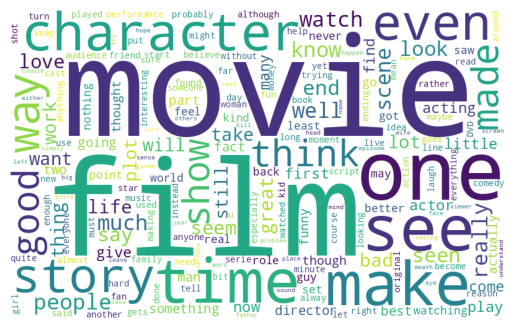

In [33]:
#Generating a word cloud of the reviews
from wordcloud import WordCloud

joined_reviews = ' '.join(df['review'])
joined_reviews = joined_reviews.replace('br', '')
wc = WordCloud(background_color='white', width = 800, height = 500).generate(joined_reviews)
plt.axis("off")
plt.imshow(wc)

##Using nltk to download stopwords. We are removing 'not' from the list of stopwords as the word is relevant to positive or negative sentiments


In [34]:
#Download stopwords
nltk.download('stopwords')
ps = PorterStemmer()

stopwords = stopwords.words('english')
#Removing 'not' from the list of stopwords
stopwords.remove('not')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


We removed 'not' from the list of stopwords to account for the relevance of negation words in sentiment analysis ([Reitan et al.,](https://www.researchgate.net/publication/301448910_Negation_Scope_Detection_for_Twitter_Sentiment_Analysis) 2015).

#Processing the reviews

In [35]:
#Running a loop to remove all special characters from the reviews, convert the reviews to lowercase, seperate each word and stem the words
#Finally, add the processed reviews to a list called corpus

from tqdm import tqdm

corpus=[]

for i in tqdm(range(0, 50000), desc='Processing'):
  review = re.sub('[^a-zA-Z]', ' ', df['review'][i])
  review = review.split()
  review = [ps.stem(word) for word in review if not word in set(stopwords)]
  review = ' '.join(review)
  corpus.append(review)

Processing: 100%|██████████| 50000/50000 [03:57<00:00, 210.36it/s]


##In order to appropraitely choose the right parameters for countvectorizer, we need to properly visualize our word list to understand the word distribution and frequency. With this action, we can tell which words needs to be further ommited and what the threshold should be for the number of words to include in our model

In [36]:
#Build a word frequency dataframe
from collections import Counter

word_count = Counter()

for sentence in corpus:
    word_count.update(sentence.split())

word_frequency = dict(word_count)
wf = pd.DataFrame(list(word_frequency.items()), columns=['words', 'frequency'])

#Sort the word frquency dataframe
wf = wf.sort_values(by='frequency', ascending=False)
wf.head()

,words,frequency
11,br,201954
82,i,164543
279,movi,103284
144,film,95890
12,the,92993


##We use countvectorizer from sklearn to create a vector of words from the list of words in corpus based on the frequency of each word.

In [37]:
#Initialize countvectorizer as cv.
cv = CountVectorizer(max_features = len(wf[wf['frequency'] >= 1000]), stop_words=['br'], lowercase=False)
#Use the initialized cv to transform corpus. Assign the generated vector of words to X
X = cv.fit_transform(corpus).toarray()
#Assign the sentiment column from our original dataframe to a variable called y
y = df.iloc[:, -2].values

Above we limit the cv fuction to only consider the words that occurs at least 1000 times, we ignore 'br' which is perhaps a leftover from the html document conversion process and we ensure that the case of each word is preserved since the case of each word may carry some value for our analysis.

In [38]:
#Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

##We use the Gaussian Naive Bayes classifier to build our model.

In [39]:
#Initilize the classifier
classifier = GaussianNB()
#Fit the model
classifier.fit(X_train, y_train)

GaussianNB()

In [40]:
#Use the model to make predictions
y_pred = classifier.predict(X_test)

#Generate model performance metrics
cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Our model performed well with an accuracy score of ' + str(accuracy_score(y_test, y_pred)*100) + '%' + " and a precision score of " + str(round(precision_score(y_test, y_pred)*100, 2)) + '%')

[[4205  830]
 [1189 3776]]
Our model performed well with an accuracy score of 79.81% and a precision score of 81.98%
